<a href="https://colab.research.google.com/github/hydrationn/AI-based-Representation-and-Problem-Solving/blob/main/20240320_3%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_2_sequence_to_sequence_for_date_translation_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human-Machine Date Translation using Sequence-to-Sequence Learning

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This educational exercise serves as an implementation code to aid in understanding sequence-to-sequence learning and is the second project in a series of two. We will tackle a very simple **toy translation** problem using sequence-to-sequence learning.


<img src="https://www.dropbox.com/scl/fi/81ex3dl202sh1vpnld1qg/date-translation.png?rlkey=eidtqpbfh6wcs0u20h6qjg0ju&dl=1" alt="archtecture" width="200" height="auto">


## Task Description

The task at hand is to create a sequence-to-sequence model that can take varied human-readable date formats, such as "NOVEMBER 18, 2001", and translate them into a standardized machine-readable format, "2001-11-18". This task not only involves understanding and parsing different textual representations of dates but also requires the model to accurately reflect the same temporal information in a consistent format.

### Goals

1. **Understand diverse date formats**: The model should be capable of interpreting various formats in which dates are written, including but not limited to full month names, abbreviations, and numerical representations.
2. **Standardize date representation**: Convert any given date format into a single, consistent machine-readable format that can be easily processed by other systems.
3. **Educational Insight**: Through this task, learners will gain insights into the workings of sequence-to-sequence models, data preprocessing for NLP tasks, and the practical application of these models in data normalization tasks.




In [1]:
!pip install -q transformers==4.36.2
!pip install -q accelerate==0.21.0
!pip install -q datasets
!pip install -q sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

## Dataset Composition

The dataset for this task includes pairs of human-readable and machine-readable date formats. To prepare and access the dataset, follow the instructions provided in the [link](https://github.com/datalogue/keras-attention.git). The dataset needs to be downloaded and properly set up before proceeding with the model training.

### Data Preparation Steps

1. **Downloading the dataset**: Use the provided script to download and unzip the dataset containing the date formats.
2. **Loading and examining the dataset**: Utilize the `datasets` library to load the data and inspect its structure, ensuring it contains the expected "human" and "machine" format pairs.





In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def set_seed_everything(seed=42):
    # Fix the random number generator seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Use deterministic algorithms and disable benchmark mode
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_seed_everything(42)

In [5]:
#!mkdir data
!rm data.zip
!rm -r data
!wget 'https://www.dropbox.com/scl/fi/mtqihg8u0kj46cqz0kukc/human_machine_dataset.zip?rlkey=k4x5b426witjygtvi9cmw52iv&dl=1' -O data.zip
!unzip data.zip -d data/

rm: cannot remove 'data.zip': No such file or directory
rm: cannot remove 'data': No such file or directory
--2024-03-26 22:26:33--  https://www.dropbox.com/scl/fi/mtqihg8u0kj46cqz0kukc/human_machine_dataset.zip?rlkey=k4x5b426witjygtvi9cmw52iv&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uceb3a6f653734c2aaebaec799d6.dl.dropboxusercontent.com/cd/0/inline/CP0J5ydm7p2ybxecpzC6uap93aLBunMa-J_y3O8zBjZ8bHBjiptmaJDUUe6yjq3tXgupZvVHeDxmApb2IZOyn_nycHUSU94K_Vck4f6Lm7Iu4yHWz07E8e_RIXQ4u5kSsRw/file?dl=1# [following]
--2024-03-26 22:26:34--  https://uceb3a6f653734c2aaebaec799d6.dl.dropboxusercontent.com/cd/0/inline/CP0J5ydm7p2ybxecpzC6uap93aLBunMa-J_y3O8zBjZ8bHBjiptmaJDUUe6yjq3tXgupZvVHeDxmApb2IZOyn_nycHUSU94K_Vck4f6Lm7Iu4yHWz07E8e_RIXQ4u5kSsRw/file?dl=1
Resolving uceb3a6f653734c2aaebaec799d6.dl.dropbo

### Loading and Examining the Dataset


In [6]:
from datasets import load_from_disk
data_dir = './'
dataset_name = 'data'
dataset_directory = os.path.join(data_dir, dataset_name)
dataset = load_from_disk(dataset_directory)
print("Loaded dataset:", dataset)

# visulaize dataset with pandas
import pandas as pd
data = {'human': dataset['train']['human'], 'machine': dataset['train']['machine'] }
df = pd.DataFrame(data)
df

Loaded dataset: DatasetDict({
    train: Dataset({
        features: ['human', 'machine'],
        num_rows: 500000
    })
    validation: Dataset({
        features: ['human', 'machine'],
        num_rows: 1000
    })
})


,human,machine
0,"12, Sep 2010",2010-09-12
1,DECEMBER 14 1992,1992-12-14
2,8 JUN 1999,1999-06-08
3,11.03.00,2000-03-11
4,6/16/79,1979-06-16
...,...,...
499995,"1 APRIL, 2008",2008-04-01
499996,"23 june, 2019",2019-06-23
499997,4/25/81,1981-04-25
499998,19 dec 1970,1970-12-19


## Model Overview

For this task, we will leverage a transformer-based encoder-decoder model, specifically the T5 model, known for its effectiveness in various NLP tasks, including sequence-to-sequence translation. This section will detail the model setup, including tokenization, which is crucial for preparing textual data for transformer models.

### Tokenization and Data Processing

Before feeding the data into the model, it must be tokenized. This process involves converting the textual data into a format that the model can understand, typically involving mapping words or characters to numerical IDs. The tokenizer will also handle necessary steps such as padding sequences to a uniform length and creating attention masks, which help the model differentiate between meaningful data and padding.


## Preparing the Model

Given the relatively simple nature of the problem, a very small seq2seq model should suffice. We will use a well-known transformer-based encoder-decoder model called T5 as our sequence to sequence model.

In the following, we will primarily use functional forms provided by huggingface. Don't worry if you're not familiar with huggingface. Think of it as a library that simplifies model downloading and input/output processing for transformers.

In [7]:
## Dataset Tokenization (with hugginface tokenizer)
MODEL_ID = "t5-small"

import transformers
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

# fast version ?
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [8]:
max_token_length = 64

def preprocess_function(examples):
    inputs  = [ex for ex in examples['human']]
    targets = [ex for ex in examples['machine']]

    tokenized_examples = tokenizer(
                            inputs,
                            text_target=targets,
                            max_length=max_token_length,
                            truncation=True
                         )
    return tokenized_examples

The dataset consists of columns named 'human' and 'machine'.

In [9]:
# print the preprocessed sample
print(preprocess_function(dataset['train'][:2]).keys())
out = preprocess_function(dataset['train'][:2])
print(out)
print("-"*50)
print("Input Tokens  : ", out['input_ids'][0])
print("Input IDs     : ", tokenizer.decode(out['input_ids'][0]) )
print("-"*50)
print("Output Tokens : ", out['labels'][0])
print("Output IDs    : ", tokenizer.decode(out['labels'][0]) )
print("-"*50)

dict_keys(['input_ids', 'attention_mask', 'labels'])
{'input_ids': [[10440, 12219, 2735, 1], [3396, 254, 6037, 12920, 968, 9047, 1]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]], 'labels': [[2735, 18, 4198, 5947, 1], [9047, 5947, 11590, 1]]}
--------------------------------------------------
Input Tokens  :  [10440, 12219, 2735, 1]
Input IDs     :  12, Sep 2010</s>
--------------------------------------------------
Output Tokens :  [2735, 18, 4198, 5947, 1]
Output IDs    :  2010-09-12</s>
--------------------------------------------------


Huggingface, a popular library for natural language processing tasks, provides a tokenizer that helps in preparing text data for models by converting text into a format that models can understand. After tokenization, it commonly returns the following pieces of information:

1. **input_ids**: These are sequences of integers representing the input text. Each integer corresponds to a specific token in the tokenizer's vocabulary. This conversion from text to integers allows the model to process and understand the text. For instance, the sentence "Hello, world!" might be tokenized into `['Hello', ',', 'world', '!']`, and then further converted into a sequence of integers like `[125, 16, 878, 58]` based on the tokenizer's vocabulary.

2. **attention_mask**: This is a sequence of 1s and 0s indicating which tokens in the `input_ids` should be attended to, and which should be ignored. The attention mask helps the model differentiate between the actual content and the padding (the values added to make all sequences in a batch the same length). For example, if the maximum length is set to 5, and our `input_ids` for "Hello, world!" are `[125, 16, 878, 58]`, the attention mask would be `[1, 1, 1, 1, 0]`, indicating that the last position is padding and should not be attended to.

3. **labels**: In the context of training, `labels` are typically used to provide the correct output for the given input text, which the model will learn to predict. The format of `labels` depends on the specific task. For a classification task, `labels` might be a single integer representing the class label. For a token classification task, such as named entity recognition, `labels` would be a sequence of integers corresponding to the class labels for each token in the input.


In [10]:
# do all tokenization
tokenized_datasets = dataset.map(
                        preprocess_function,
                        batched=True,
                        remove_columns=dataset["train"].column_names,
                     )
train_dataset = tokenized_datasets["train"]
valid_dataset = tokenized_datasets["validation"]
print(tokenized_datasets)

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})


### Model Preparation

With our model defined, we'll now compile and train it on our dataset. This section will explain the training process.

In [11]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

sample_batch = [tokenized_datasets["train"][i] for i in range(1, 3)]
print( sample_batch[0] )
print( sample_batch[1] )

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

{'input_ids': [3396, 254, 6037, 12920, 968, 9047, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'labels': [9047, 5947, 11590, 1]}
{'input_ids': [505, 446, 7443, 5247, 1], 'attention_mask': [1, 1, 1, 1, 1], 'labels': [5247, 18, 5176, 18, 4018, 1]}


### Preparing Evaluation Metrics
The code below defines a function to measure the model's performance during or after training.

Since we need to compare the machine-generated date strings with the actual answer strings, we will use the BLEU score.

In [12]:
from datasets import load_dataset, load_metric
metric = load_metric("sacrebleu")

import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    return result

<ipython-input-12-17e7a5311039>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### Defining Training Arguments

In [13]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    f"{MODEL_ID}-human-machine-translation",
    ## ---- Epoch & Batch ----- ##
    num_train_epochs=2,
    per_device_train_batch_size=1024,

    ## ---- Learning Rate ----- ##
    weight_decay=0.01,
    learning_rate=2e-5,

    ## - Logging & Checkpoint - ##
    logging_dir='./logs/human-machine-translation/tensorboard',  # Directory for TensorBoard logs
    report_to="tensorboard",  # Enable TensorBoard logging
    logging_steps=10,
    save_steps=1000,

    ## ---- Evaluations ----- ##
    predict_with_generate=True,
    evaluation_strategy="epoch",
)

## Training
Define the training and testing data and specify which function to use for evaluation.

In [14]:
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,

    # on Which Dataset
    train_dataset=train_dataset,  # < train
    eval_dataset=valid_dataset,   # < test

    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./results")


Epoch,Training Loss,Validation Loss,Bleu
1,0.162200,0.046968,98.777087
2,0.103800,0.030397,98.952301


### Progress Check

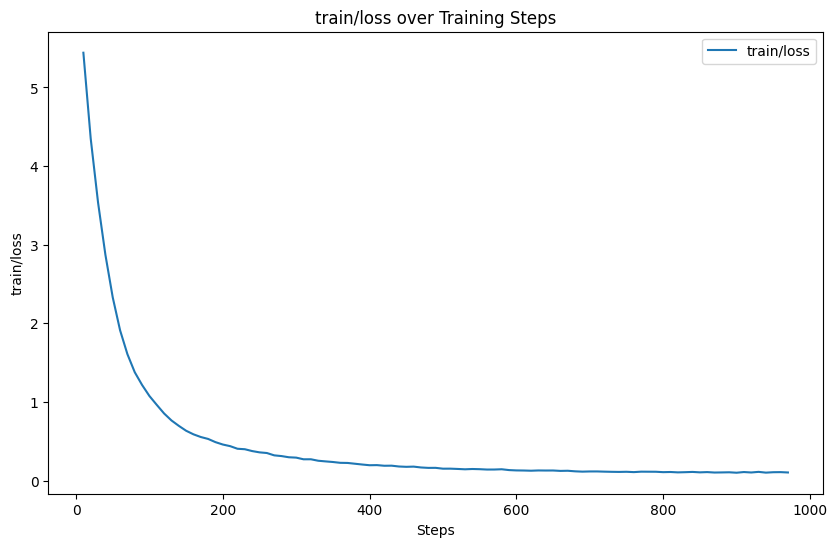

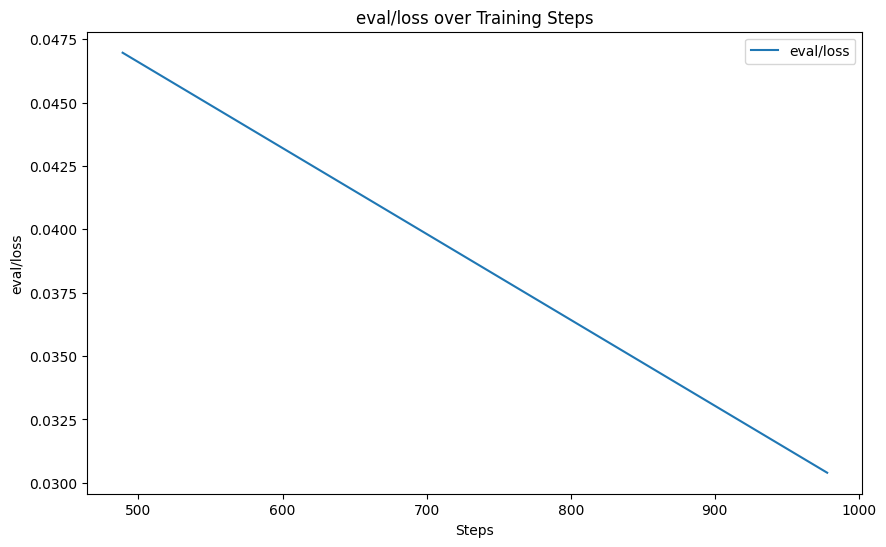

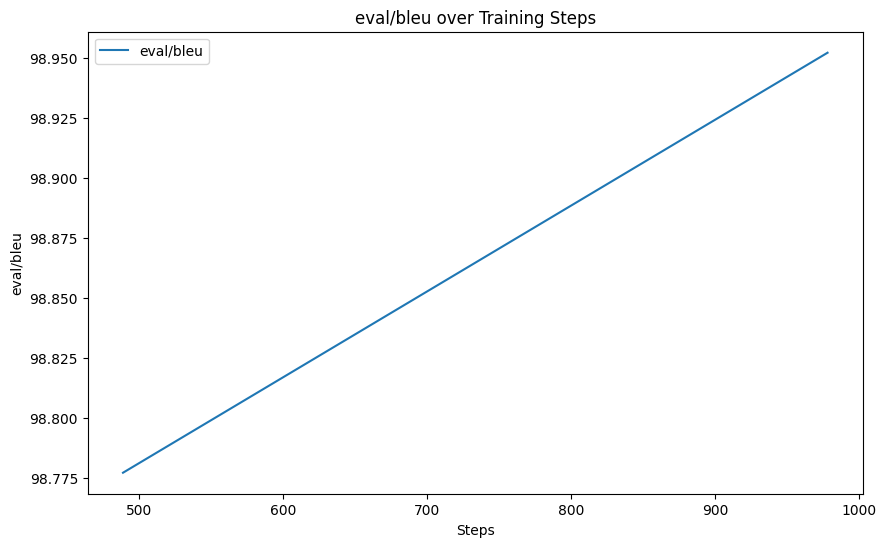

In [15]:
# ---- Monitoring the result ---- #
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

# Path to the TensorBoard log directory
log_dir = './logs/human-machine-translation/tensorboard'

# Load the TensorBoard event file
event_file = next(os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events.out.tfevents' in f)
ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

# Function to plot TensorBoard scalars
def plot_tensorboard_scalars(scalar_key):
    scalar_data = ea.Scalars(scalar_key)

    steps = [point.step for point in scalar_data]
    values = [point.value for point in scalar_data]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label=scalar_key)
    plt.xlabel('Steps')
    plt.ylabel(scalar_key)
    plt.title(f'{scalar_key} over Training Steps')
    plt.legend()
    plt.show()


# Replace 'loss' with the actual key you used for logging
# You can also add more keys and call plot_tensorboard_scalars for each
plot_tensorboard_scalars('train/loss')

# If you logged evaluation metrics like 'eval_loss', 'eval_bleu', you can plot them in a similar way
plot_tensorboard_scalars('eval/loss')
plot_tensorboard_scalars('eval/bleu')

When we look at the loss function curve, we can see that the training is going very well, and especially if we look at the BLEU score, we can tell that it is showing quite high performance from the very initial steps.

## Testing
Reload the trained model and perform human-machine translation.




### Loading the Model

In [16]:
max_token_length = 64
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_dir = "./results"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

print(model)
model.cpu()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [17]:
input_texts = dataset['validation']['human'][:50]
inputs = tokenizer(input_texts,
                   return_tensors="pt",
                   padding=True,
                   max_length=max_token_length)

ref_texts = dataset['validation']['machine'][:50]

outputs = model.generate(
    **inputs,
    max_length=max_token_length,
    num_beams=5,
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2636: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


### Inference(Translation)

In [18]:
# skip special symbols including padding
output_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# visualization output with pandas
import pandas as pd
data = {'human': input_texts, 'predicted_machine':output_texts, 'reference_machine':ref_texts}
df = pd.DataFrame(data)
df['correct'] = df.apply(lambda x : "O" if x.predicted_machine == x.reference_machine else "X", axis=1)
print(df)

                         human predicted_machine reference_machine correct
0                       7/4/70        1970-07-04        1970-07-04       O
1             February 7, 1988        1988-02-07        1988-02-07       O
2                     26.12.93        1993-12-26        1993-12-26       O
3                     19.03.19        2019-03-19        2019-03-19       O
4        FRIDAY, MARCH 1, 1974        1974-03-01        1974-03-01       O
5                  14 Jun 2017        2017-06-14        2017-06-14       O
6         Monday, May 15, 1978        1978-05-15        1978-05-15       O
7                 march 9 1991        1991-03-09        1991-03-09       O
8                  30 Jun 1975        1975-06-30        1975-06-30       O
9                JULY 12, 2000        2000-07-12        2000-07-12       O
10            November 10 1991        1991-11-10        1991-11-10       O
11                    03.05.83        1983-05-03        1983-05-03       O
12             February 6

## Conclusion

Upon completing this tutorial, learners will have a solid understanding of applying sequence-to-sequence models to practical translation tasks, specifically translating human-readable dates into a standardized format that can be easily processed by machines. This project showcases the power of modern NLP models and provides a foundation for tackling more complex sequence transformation tasks.